<a href="https://colab.research.google.com/github/kumiori/mec647/blob/Wissam-meshes/3crackholes(energy).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
import sys

try:
    import google.colab  # noqa: F401
except ImportError:
    import ufl  # noqa: F401
    import dolfinx  # noqa: F401
else:
    try:
        import ufl
        import dolfinx
    except ImportError:
        !wget "https://fem-on-colab.github.io/releases/fenicsx-install.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh";
        import ufl  # noqa: F401
        import dolfinx  # noqa: F401

try:
    import pyvista
except ImportError:
    !{sys.executable} -m pip install --upgrade pyvista itkwidgets;
    import pyvista  # noqa: F401
    from pyvista.utilities import xvfb

try:
    import gmsh
except ImportError:
    !{sys.executable} -m pip install gmsh
    import gmsh

!sudo apt install libgl1-mesa-glx xvfb;
!{sys.executable} -m pip install pythreejs;
!{sys.executable} -m pip install ipygany;
!{sys.executable} -m pip install --upgrade PyYAML
# !pip install --ignore-installed PyYAML


!sudo apt install libgl1-mesa-glx xvfb;
!{sys.executable} -m pip install pythreejs;
!{sys.executable} -m pip install ipygany;
!{sys.executable} -m pip install --upgrade PyYAML
# !pip install --ignore-installed PyYAML



branch_name = 'main'

!rm -rf mec647
try:
  !git clone -b {branch_name} https://github.com/kumiori/mec647.git
except Exception:
  print('Something went wrong')
  !rm -rf mec647
  !git clone https://github.com/kumiori/mec647.git


sys.path.append('mec647/')



import matplotlib.pyplot as plt
from petsc4py import PETSc
import numpy as np
from mpi4py import MPI

comm = MPI.COMM_WORLD

from dolfinx.fem import (
    Constant,
    Function,
    FunctionSpace,
    assemble_scalar,
    dirichletbc,
    form,
    locate_dofs_geometrical,
    set_bc,
)

# meshes
import meshes
from meshes import primitives

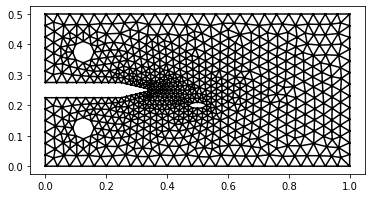

In [ ]:
from utils.viz import plot_mesh

from mpi4py import MPI

parameters = {
    'loading': {
        'type':'ID', #ID -> Imposed Displacement | IF -> Imposed Force
        'min': 0,
        'max': 1,
        'steps': 10
    },
    'geometry': {
        'geom_type': 'bar',
        'Lx': 1.,
        'Ly': 0.5
    },
    'model': {
        'E': 1.,
        'nu': 0.,
        'w1': 1.,
        'ell': 0.1,
        'k_res': 1.e-8
    },
    'solvers': {
          'elasticity': {        
            'snes': {
                'snes_type': 'newtontr',
                'snes_stol': 1e-8,
                'snes_atol': 1e-8,
                'snes_rtol': 1e-8,
                'snes_max_it': 100,
                'snes_monitor': "",
                'ksp_type': 'preonly',
                'pc_type': 'lu',
                'pc_factor_mat_solver_type': 'mumps'
            }
        },
          'damage': {        
            'snes': {
                'snes_type': 'vinewtonrsls',
                'snes_stol': 1e-5,
                'snes_atol': 1e-5,
                'snes_rtol': 1e-8,
                'snes_max_it': 100,
                'snes_monitor': "",
                'ksp_type': 'preonly',
                'pc_type': 'lu',
                'pc_factor_mat_solver_type': 'mumps'
            },
        },

                'damage_elasticity': {
                "max_it": 100,
                "alpha_rtol": 1.0e-5,
                "criterion": "alpha_H1"
            }
    }
}


def  mesh_crackholes(name,
                     Lx,
                     Ly,
                     a,
                     b,
                     lc,
                     tdim,
                     order=1,
                     msh_file=None,
                     comm=MPI.COMM_WORLD):
    """
    Create mesh of 3d tensile test specimen according to ISO 6892-1:2019 using the Python API of Gmsh.
    """
    # Perform Gmsh work only on rank = 0

    if comm.rank == 0:

        import gmsh

        # Initialise gmsh and set options
        gmsh.initialize()
        gmsh.option.setNumber("General.Terminal", 1)

        gmsh.option.setNumber("Mesh.Algorithm", 6)
        model = gmsh.model()
        model.add("Rectangle")
        model.setCurrent("Rectangle")
        # points = [p1, p2, p3, p4, p5, p6, p7, p8,p9,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,p21,p22,p23,p24,p25,p26]
        p1 = model.geo.addPoint(0.0, 0.0, 0, lc, tag=1)
        p2 = model.geo.addPoint(Lx, 0.0, 0, lc, tag=2)
        p3 = model.geo.addPoint(Lx, Ly, 0.0, lc, tag=3)
        p4 = model.geo.addPoint(0, Ly, 0, lc, tag=4)
        p5 = model.geo.addPoint(0, 0.275, 0.0, lc, tag=5)
        p6 = model.geo.addPoint(Lx/4, 0.275, 0, lc/2, tag=6)
        p7 = model.geo.addPoint(0.35, (Ly/2)+0.001, 0.0, lc/3, tag=7)
        p8 = model.geo.addPoint(0.40, 0.25, 0, lc/3 , tag=8)
        p9 = model.geo.addPoint(0.35, (Ly/2)-0.001, 0, lc/3, tag=9)
        p10 = model.geo.addPoint(Lx/4, 0.225, 0, lc/2, tag=10)
        p11 = model.geo.addPoint(0, 0.225, 0, lc, tag=11)
        p12 = model.geo.addPoint(0.125, 0.375, 0, lc, tag=12) #cercle1
        p13 = model.geo.addPoint(0.10, 0.40, 0, lc, tag=13)
        p14 = model.geo.addPoint(0.15, 0.40, 0, lc, tag=14)
        p15 = model.geo.addPoint(0.15, 0.35, 0, lc, tag=15)
        p16 = model.geo.addPoint(0.10, 0.35, 0, lc, tag=16)
        p17 = model.geo.addPoint(0.125, 0.125, 0, lc, tag=17) #cercle2
        p18 = model.geo.addPoint(0.10, 0.15, 0, lc, tag=18)
        p19 = model.geo.addPoint(0.15, 0.15, 0, lc, tag=19)
        p20 = model.geo.addPoint(0.15, 0.10, 0, lc, tag=20)
        p21 = model.geo.addPoint(0.10, 0.10, 0, lc, tag=21)
        p22 = model.geo.addPoint(a,b, 0, lc, tag=22) #ellipse
        p23 = model.geo.addPoint(a,b+0.01, 0, lc, tag=23)
        p24 = model.geo.addPoint(a+0.03,b, 0, lc, tag=24)
        p25 = model.geo.addPoint(a,b-0.01, 0, lc, tag=25)
        p26 = model.geo.addPoint(a-0.03,b, 0, lc, tag=26)

        # Lines = [L1, L2, L3, L4, L5, L6, L7, L8]
        bottom = model.geo.addLine(p1, p2, tag=1)
        right= model.geo.addLine(p2, p3, tag=2)
        top = model.geo.addLine(p3, p4, tag=3)
        left1= model.geo.addLine(p4, p5, tag=4)
        halftop= model.geo.addLine(p5, p6, tag=5)
        inclined1= model.geo.addLine(p6, p7, tag=6)
        liptop= model.geo.addLine(p7, p8, tag=7)
        lipbot = model.geo.addLine(p8, p9, tag=8)
        inclined2= model.geo.addLine(p9, p10, tag=9)
        halfbottom= model.geo.addLine(p10, p11, tag=10)
        left2= model.geo.addLine(p11, p1, tag=11)
        cloop1 = model.geo.addCurveLoop([bottom, right, top, left1, halftop,inclined1,liptop,lipbot,inclined2,halfbottom,left2]) 
        c1 = gmsh.model.geo.addCircleArc(p13, p12, p14)
        c2 = gmsh.model.geo.addCircleArc(p14, p12, p15)
        c3 = gmsh.model.geo.addCircleArc(p15, p12, p16)
        c4 = gmsh.model.geo.addCircleArc(p16, p12, p13)
        circle1 = model.geo.addCurveLoop([c1, c2, c3, c4])
        c5 = gmsh.model.geo.addCircleArc(p18, p17, p19)
        c6 = gmsh.model.geo.addCircleArc(p19, p17, p20)
        c7 = gmsh.model.geo.addCircleArc(p20, p17, p21)
        c8 = gmsh.model.geo.addCircleArc(p21, p17, p18)
        circle2 = model.geo.addCurveLoop([c5, c6, c7, c8])
        e1= gmsh.model.geo.addEllipseArc(p26, p22, p24,p25)
        e2= gmsh.model.geo.addEllipseArc(p24, p22, p26,p25)
        e3= gmsh.model.geo.addEllipseArc(p24, p22, p26,p23)
        e4= gmsh.model.geo.addEllipseArc(p26, p22, p24,p23)
        Ellipse = model.geo.addCurveLoop([e1, -e2, e3, -e4])
        
        # surface_1 =
        model.geo.addPlaneSurface([cloop1,circle1,circle2,Ellipse])

        model.geo.synchronize()
        surface_entities = [model[1] for model in model.getEntities(tdim)]

        model.addPhysicalGroup(tdim, surface_entities, tag=1)
        model.setPhysicalName(tdim, 1, "Rectangle surface")

        # Set mesh size via points
        # gmsh.model.mesh.setSize(points, lc)  # heuristic

        # gmsh.model.mesh.optimize("Netgen")

        # Set geometric order of mesh cells
        gmsh.model.mesh.setOrder(order)

        # Define physical groups for subdomains (! target tag > 0)
        # domain = 1
        # gmsh.model.addPhysicalGroup(tdim, [v[1] for v in volumes], domain)
        # gmsh.model.setPhysicalName(tdim, domain, 'domain')
              

        gmsh.model.addPhysicalGroup(tdim - 1, [5], tag=9)
        gmsh.model.setPhysicalName(tdim - 1, 9, "botfissure1")
        gmsh.model.addPhysicalGroup(tdim - 1, [6], tag=10)
        gmsh.model.setPhysicalName(tdim - 1, 10, "botfissure2")
        gmsh.model.addPhysicalGroup(tdim - 1, [3], tag=11)
        gmsh.model.setPhysicalName(tdim - 1, 11, "top")
        gmsh.model.addPhysicalGroup(tdim - 1, [1], tag=12)
        gmsh.model.setPhysicalName(tdim - 1, 12, "bottom")
        gmsh.model.addPhysicalGroup(tdim - 1, [7], tag=13)
        gmsh.model.setPhysicalName(tdim - 1, 13, "topfissure1")
        gmsh.model.addPhysicalGroup(tdim - 1, [8], tag=14)
        gmsh.model.setPhysicalName(tdim - 1, 14, "topfissure2")

        model.mesh.generate(tdim)


        #Generating the mesh
    model.geo.synchronize()
    model.mesh.generate(tdim)

    return gmsh.model

#Lx = parameters["geometry"]["Lx"]
#Ly = parameters["geometry"]["Ly"]
#geom_type = parameters["geometry"]["geom_type"]

Lx=1
Ly=0.5


gmsh_model=mesh_crackholes('mesh', 1, 0.5, 0.5,0.20,0.04, 2, 1)

mesh, facet_tags = meshes.gmsh_model_to_mesh(gmsh_model,
                               cell_data=False,
                               facet_data=True,
                               gdim=2)



from utils.viz import plot_mesh
import matplotlib.pyplot as plt
 
#Plot mesh
plt.figure()
ax = plot_mesh(mesh)
fig = ax.get_figure()
fig.savefig(f"mesh.png")

In [ ]:
# Functional setting
#'u' represents the displacement in this problem. In order to solve it, the 
#continuos field  'u' is replaced by a discrite form u = som[vec(function_forme)
#*vec(nodal_displacement)]
#In order to define the vec(function_forme), the ufl library is used. 

#A VectorElement represents a combination of basic elements such that each
#component of a vector is represented by the basic element. The size is usually
#omitted, the default size equals the geometry dimension.

#ulf.VectorElement(<Type of the element>, <Geometry of the element>, 
#degree=<Degree of element: 1 - Linear, 2 - Quadratic, etc.>, dim= <Target 
#dimension of the element: 1 - Line, 2 - Area, 3 - Volume>)

#Lagrange is a familly type of elements -> polynomial functions of forme;
#The Lagrange elements are going to be defined in the mesh as such we take the
#geometry of elements present in the mesh.

element_u = ufl.VectorElement("Lagrange", mesh.ufl_cell(),
                              degree=1, dim=2)
element_alpha = ufl.FiniteElement("Lagrange", mesh.ufl_cell(),
                              degree=1)

#After defining the Finite Element in ufl, a association with dolfinx is made.
#To inputs are necessary, the mesh and the element type created. In some sense, 
#we obtain the "discretised model w/ elements definied".
V_u = dolfinx.fem.FunctionSpace(mesh, element_u)
V_alpha = dolfinx.fem.FunctionSpace(mesh, element_alpha)

#In this model, we also defines functions necessaries to solve the problem. 
#This functions are definied in the entire space/model.
u = dolfinx.fem.Function(V_u, name="Displacement") #The discrete nodal valeus of
                                                   #the displacement
u_ = dolfinx.fem.Function(V_u, name="BC_Displacement")
u_imposed = dolfinx.fem.Function(V_u, name="Imposed_Displacement")
alpha = dolfinx.fem.Function(V_alpha, name="Damage")
# Bounds -> the values of alpha must be max([0,1],[alpha(t-1),1]) 
alpha_ub = dolfinx.fem.Function(V_alpha, name="UpperBoundDamage")
alpha_lb = dolfinx.fem.Function(V_alpha, name="LowerBoundDamage")
alpha_lb.interpolate(lambda x: np.zeros_like(x[0]))
alpha_ub.interpolate(lambda x: np.ones_like(x[0]))

#In order to defined a function in a specific subspace of the model, it must be 
#specified in the model 'V_u.sub(i)', where i = 0 -> x, 1 -> y, 2-> z.
#Don't forget to collapse, to choose only the DOF associated with the subspace.

#I don't think  this part works to definy the body force applied in a geometry.
#It could be better to define it in the energy definition as constant. If not a 
#constant, we might need to define as a space function.
# g = dolfinx.fem.Function(V_u, name="Body_pressure")
# with g.vector.localForm() as loc:
#   loc.set(-78500.0)

# Integral measures -> in order to define the energy lately, it's necessary to 
#define the integral measures, as such one is a integral.
dx = ufl.Measure("dx", domain=mesh) #-> volume measure
#We include here the subdomain data generated at the gmsh file.
ds = ufl.Measure("ds", subdomain_data = facet_tags, domain=mesh) #-> surface measure
#ds(<number of the facet tags>)
#dS = ufl.Measure("dS", domain = mesh) - inner boundaries of the mesh -> not usefull

import models
from models import DamageElasticityModel as Brittle

model = Brittle(parameters.get('model'))
state = {'u': u, 'alpha': alpha}
#The total energy density is calculated this time using a already written 
#function of the "model". This return the elasticity energy (with the a(alpha))
#and the damage energy term. To count for externals forces, it need to substract it
#from the total energy
total_energy = model.total_energy_density(state) * dx #- ufl.dot(force,u)*ds(107) - ufl.dot(force,u)*ds(108)
if parameters['loading']['type'] == 'ID':
  total_energy = model.total_energy_density(state) * dx
if parameters['loading']['type'] == 'IF':
  #Getting load parameters
  force = dolfinx.fem.Function(V_u, name="Contact_force")
  loading_force = -1*parameters['loading']['max']
  force.interpolate(lambda x: (np.zeros_like(x[0]), loading_force*np.ones_like(x[1])))
  total_energy = model.total_energy_density(state) * dx - ufl.dot(force,u)*ds(107) - ufl.dot(force,u)*ds(108)

# Boundary sets
#Function that returns 'TRUE' if the point of the mesh is in the region you want
#to apply the BC.
def BC_points(x):
  #x[0] is the vector of X-coordinate of all points ; x[1] is the vector of Y-coordinate
  return np.logical_and(
      np.logical_or(np.isclose(x[0],-Lx/2),np.isclose(x[0],Lx/2)),
      np.isclose(x[1],0))
BC_entities = dolfinx.mesh.locate_entities_boundary(mesh, 0, BC_points)
BC_dofs = dolfinx.fem.locate_dofs_topological(V_u, 0, BC_entities)
u_.interpolate(lambda x: (np.zeros_like(x[0]), np.zeros_like(x[1])))

#FOR IMPOSED FORCE :
if parameters['loading']['type'] == 'IF':
  bcs_u = [dirichletbc(u_, BC_dofs)]
#FOR IMPOSED DISPLACEMENT :
if parameters['loading']['type'] == 'ID':
  def ID_points(x):
    return np.logical_and(np.equal(x[1],Ly), 
                          np.logical_and(np.greater_equal(x[0],-1*min(Ly/40, Lx/80)),
                                                          np.less_equal(x[0],min(Ly/40, Lx/80))
                                                          ))
  ID_entities = dolfinx.mesh.locate_entities_boundary(mesh, 0, ID_points)
  ID_dofs = dolfinx.fem.locate_dofs_topological(V_u, 0, ID_entities)
  u_imposed.interpolate(lambda x: (np.zeros_like(x[0]), -0.1*parameters['loading']['max']*np.ones_like(x[1])))
  bcs_u = [dirichletbc(u_, BC_dofs),dirichletbc(u_imposed,ID_dofs)]

dofs_alpha_left = locate_dofs_geometrical(V_alpha, lambda x: np.isclose(x[0], -Lx/2))
dofs_alpha_right = locate_dofs_geometrical(V_alpha, lambda x: np.isclose(x[0], Lx/2))

bcs_alpha = [
             dirichletbc(np.array(0., dtype = PETSc.ScalarType),
                         np.concatenate([dofs_alpha_left, dofs_alpha_right]),
                         V_alpha)
]
#bcs_alpha=[]
bcs = {"bcs_u": bcs_u, "bcs_alpha": bcs_alpha}

# Update the bounds
set_bc(alpha_ub.vector, bcs_alpha)
set_bc(alpha_lb.vector, bcs_alpha)



  0 SNES Function norm 1.138075134775e+01 
  1 SNES Function norm 9.104687342260e+00 
  2 SNES Function norm 4.551719958491e+00 
  3 SNES Function norm 3.518228813560e-14 
  0 SNES Function norm 0.000000000000e+00 
Solved timestep 0, load 0.0
Elastic energy 7.82e-28, Surface energy 0
  0 SNES Function norm 1.264527927528e+00 
  1 SNES Function norm 1.261842542328e+00 
  2 SNES Function norm 1.256471273282e+00 
  3 SNES Function norm 1.245729447975e+00 
  4 SNES Function norm 1.224251524312e+00 
  5 SNES Function norm 1.181295319171e+00 
  6 SNES Function norm 1.095381404834e+00 
  7 SNES Function norm 9.235065094086e-01 
  8 SNES Function norm 5.798057659965e-01 
  9 SNES Function norm 5.417942847245e-15 
  0 SNES Function norm 0.000000000000e+00 
Solved timestep 1, load 0.1111111111111111
Elastic energy 1.41e-29, Surface energy 0
  0 SNES Function norm 1.264527927528e+00 
  1 SNES Function norm 1.011356559678e+00 
  2 SNES Function norm 5.051033590193e-01 
  3 SNES Function norm 6.711

ValueError: ignored

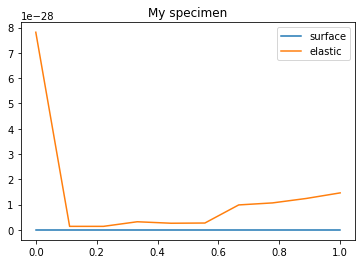

In [ ]:
import algorithms
from algorithms import am
solve_it = am.AlternateMinimisation(total_energy, 
                         state, 
                         bcs, 
                         parameters.get("solvers"), 
                         bounds=(alpha_lb,alpha_ub))

solve_it.elasticity
#Loop for evolution
Loads = np.linspace(parameters.get("loading").get("min"),
                    parameters.get("loading").get("max"),
                    parameters.get("loading").get("steps"))

data = {
    'elastic': [],
    'surface': [],
    'total': [],
    'load': []
}

for (i_t,t) in enumerate(Loads):
  #update bondary conditions
  if parameters['loading']['type'] == 'ID':
    u_imposed.interpolate(lambda x: (np.zeros_like(x[0]), 10*t*np.ones_like(x[1])))
  if parameters['loading']['type'] == 'IF':
    force.interpolate(lambda x: (np.zeros_like(x[0]), loading_force*t*np.ones_like(x[1])))
  #update lower bound for damage
  alpha.vector.copy(alpha_lb.vector)
  #solve for current load step
  solve_it.solve()
  #postprocessing
  #global
  surface_energy = assemble_scalar(dolfinx.fem.form(model.damage_dissipation_density(state)*dx))
  elastic_energy = assemble_scalar(dolfinx.fem.form(model.elastic_energy_density(state)*dx))
  
  data.get('elastic').append(elastic_energy)
  data.get('surface').append(surface_energy)
  data.get('total').append(surface_energy+elastic_energy)
  data.get('load').append(t)
  
  print(f'Solved timestep {i_t}, load {t}')
  print(f'Elastic energy {elastic_energy:.3g}, Surface energy {surface_energy:.3g}')

  #saving


plt.plot(data.get('load'), data.get('surface'), label='surface')
plt.plot(data.get('load'), data.get('elastic'), label='elastic')
#plt.plot(data.get('load'), [1./2. * t**2*L for t in data.get('load')], label='anal elast', ls=':', c='k')

plt.title('My specimen')
plt.legend()
#plt.yticks([0, 1/20], [0, '$1/2.\sigma_c^2/E_0$'])
#plt.xticks([0, 1], [0, 1])

try:
    from dolfinx.plot import create_vtk_mesh as compute_topology
except ImportError:
    from dolfinx.plot import create_vtk_topology as compute_topology
    
def plot_scalar(alpha, plotter, subplot=None, lineproperties={}):
    if subplot:
        plotter.subplot(subplot[0], subplot[1])
    V = alpha.function_space
    mesh = V.mesh
    
    # topology, cell_types = dolfinx.plot.create_vtk_mesh(mesh, mesh.topology.dim)
    # topology, cell_types = dolfinx.plot.create_vtk_topology(
        # mesh, mesh.topology.dim)
    topology, cell_types = compute_topology(mesh, mesh.topology.dim)
    grid = pyvista.UnstructuredGrid(topology, cell_types, mesh.geometry.x)

    plotter.subplot(0, 0)
    grid.point_data["alpha"] = alpha.compute_point_values().real
    grid.set_active_scalars("alpha")
    plotter.add_mesh(grid, **lineproperties)
    plotter.view_xy()
    return plotter

# postprocessing
xvfb.start_xvfb(wait=0.05)
pyvista.OFF_SCREEN = True
plotter = pyvista.Plotter(
        title="Displacement",
        window_size=[1600, 600],
        shape=(1, 2),
    )
_plt = plot_scalar(alpha, plotter, subplot=(0, 0))
_plt.screenshot(f"alpha.png")